# Job Description Sentence Categorizer

This notebook demonstrates how we used GPT-5 nano to automatically label each sentence in a job posting as **Marketing**, **Description**, **Requirements**, or **Legal**.

<!-- Note for us -- if we're only using this notebook for demo purposes, should we just clean and classify like 10 descriptions so it doesn't take forever to run? We can do the data processing in a different python file? -->

# Setup

### Imports

In [42]:
import pandas as pd
import sys
import matplotlib as plt

sys.path.append("../src")
from preprocessing import clean_text
from classifier import GPTJobDescriptionClassifier
from IPython.display import display

### Load and Prepare Data

In [19]:
# Load dataset
df = pd.read_csv("../Engineer_20230826.csv")

# Drop JobTitle column because it has the same value for all entries and therefore no predictive value
# df = df[["RequisitionID", "OrigJobTitle", "JobDescription"]].dropna()

# Clean text
df['JobDescription'] = df['JobDescription'].apply(clean_text)

df.head(3)

,RequisitionID,OrigJobTitle,JobTitle,JobDescription
0,NaN,Licensed Stationary Engineer,ENGINEER (all other),Licensed Stationary Engineer Froedtert South K...
1,00000224907,Guidance Navigation and Control (GN&C) Enginee...,ENGINEER (all other),The Boeing Company is in search of a Lead Guid...
2,00000331804,"Propulsion Engineer - Associate, Mid-Level and...",ENGINEER (all other),"Job Description At Boeing, we innovate and col..."


## Initialize Classifier

Let's run our job description classifier on 500 samples from our dataset.

In [20]:
classifier = GPTJobDescriptionClassifier(job_postings_data=df, n_samples=1)
res = classifier.process_random_postings()

You can see the exact prompt that we give GPT-5 for some arbitrary job post we selected:

In [21]:
sample_post = df.iloc[0]["JobDescription"]
print(classifier.build_prompt(sample_post)[:800])


Analyze the following job posting and categorize each sentence into one of these four categories:
- Marketing: Sentences that sell the company, highlight benefits, or promote the organization
- Description: Sentences describing job duties, responsibilities, and day-to-day work
- Requirements: Sentences listing qualifications, skills, experience, or education needed
- Legal: Sentences about EEO statements, compliance, disclaimers, or legal notices

Job Posting:
Licensed Stationary Engineer Froedtert South Kenosha, WI (Onsite) Full-Time Apply on company site Job Details + POSITION PURPOSE + Duties consist of checking equipment and facilities for proper operation of HVAC systems, pumps, electrical distribution and other essential systems throughout the hospital. Duties also include the repai


## Explore Results

Our results are formatted in a table with 4 columns:
- Sentence - copies the exact sentence from the job description
- Category - which of the 4 categories (Marketing, Description, Requirement, Legal) our classifier categorized it as.
- Kept the original columns RequisitionID and JobTitle 
<!-- note for future self -- change this to OrigJobTitle because that would be more useful than JobTitle -->

In [31]:
print(list(res.columns))

res.head()

['sentence', 'category', 'RequisitionID', 'JobTitle']


,sentence,category,RequisitionID,JobTitle
0,"In a world of possibilities, pursue one with e...",Marketing,R144333,ENGINEER (all other)
1,Imagine Next!,Marketing,R144333,ENGINEER (all other)
2,"When it comes to what you want in your career,...",Marketing,R144333,ENGINEER (all other)
3,"Imagine a career working with intelligent, div...",Marketing,R144333,ENGINEER (all other)
4,Imagine a workplace where you can be yourself.,Marketing,R144333,ENGINEER (all other)


## Isolate a Single Job Description

In [44]:
single_posting = df.iloc[0]

# Display the job description
print(single_posting["JobDescription"])

# Categorize the posting
categorized_df = classifier.categorize_posting(single_posting)

# Define lighter, readable colors
category_colors = {
    "Marketing": "#d0e7ff",      # very light blue
    "Description": "#dfffd0",    # very light green
    "Requirements": "#fffacd",   # light yellow (like lemon chiffon)
    "Legal": "#ffd9d9"           # very light red/pink
}

# Apply styling with readable colors
def color_rows(row):
    return ['background-color: {}'.format(category_colors.get(row['category'], '#ffffff'))]*len(row)

styled_df = categorized_df[['sentence', 'category']].style.apply(color_rows, axis=1)
styled_df

Licensed Stationary Engineer Froedtert South Kenosha, WI (Onsite) Full-Time Apply on company site Job Details + POSITION PURPOSE + Duties consist of checking equipment and facilities for proper operation of HVAC systems, pumps, electrical distribution and other essential systems throughout the hospital. Duties also include the repair and maintenance of the systems. It requires frequent and consistent walking through different mechanical equipment rooms, going up and down stairs, ladders, and ramps. + MINIMUM EDUCATION REQUIRED + High School plus specialized training (6 mons-2 yrs) + MINIMUM EXPERIENCE REQUIRED + 1 to 3 years + LICENSES / CERTIFICATIONS REQUIRED + Graduate of a trade or vocational school with courses pertinent to the job duties preferred. + Licensure to be eligible to practice as a Licensed Stationary Engineer from the National Institute of Power Engineers (NIPE) or from the American Society of Power Engineers or the ability to obtain licensure within 12 months of hire.

,sentence,category
0,"Duties consist of checking equipment and facilities for proper operation of HVAC systems, pumps, electrical distribution and other essential systems throughout the hospital.",Description
1,Duties also include the repair and maintenance of the systems.,Description
2,"It requires frequent and consistent walking through different mechanical equipment rooms, going up and down stairs, ladders, and ramps.",Description
3,Graduate of a trade or vocational school with courses pertinent to the job duties preferred.,Requirements
4,Licensure to be eligible to practice as a Licensed Stationary Engineer from the National Institute of Power Engineers (NIPE) or from the American Society of Power Engineers or the ability to obtain licensure within 12 months of hire.,Requirements
5,Must be familiar with hand tools and power tools.,Requirements
6,Must have three to six (3-6) months of job training or equivalent military training.,Requirements
7,"Ability to read, write, speak, hear, and comprehend the English language.",Requirements
8,Must be able to interpret and understand water treatment and treatment chemical levels.,Requirements
9,Manual dexterity is required to perform repairs and maintenance.,Requirements


Let's see what percentage of sentences fall into the 4 categories:

[Text(0, 0, 'Marketing'),
 Text(1, 0, 'Description'),
 Text(2, 0, 'Requirements'),
 Text(3, 0, 'Legal')]

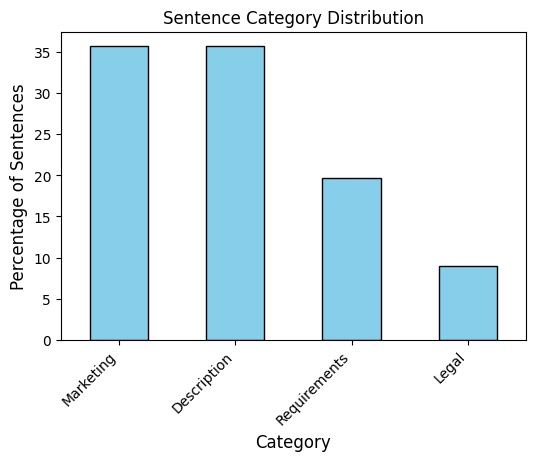

In [38]:
# Count of sentences per category
category_counts = res["category"].value_counts(normalize=True) * 100  # convert to percentages

ax = category_counts.plot(
    kind="bar",
    title="Sentence Category Distribution",
    figsize=(6, 4),
    color="skyblue",
    edgecolor="black"
)

ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("Percentage of Sentences", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")